In [1]:
import pystac
import stac2dcache

from stac2dcache.utils import copy_asset, get_asset, catalog2geopandas 

# Explore shadow catalog

In [2]:
# the dcache API URL is not needed to download/upload data
# DCACHE_API_URL = "https://dcacheview.grid.surfsara.nl:22880/api/v1"
DCACHE_WEBDAV_URL = "https://webdav.grid.surfsara.nl:2880"

In [3]:
dcache_root = (DCACHE_WEBDAV_URL  
    + "/pnfs/grid.sara.nl/data/eratosthenes/disk/")

# catalog with shadow-enhanced images
catalog_id = "red-glacier_sentinel-2_shadows"
catalog_url = dcache_root + catalog_id

In [4]:
# configure connection to dCache
dcache = stac2dcache.configure(
    filesystem="dcache", 
    token_filename="macaroon.dat"
)
# dcache.api_url = DCACHE_API_URL

In [5]:
def read_catalog(url):
    """
    Read STAC catalog from URL
    
    :param url: urlpath to the catalog root
    :return: PySTAC Catalog object
    """
    url = url if url.endswith("catalog.json") else f"{url}/catalog.json"
    catalog = pystac.Catalog.from_file(url)
    return catalog

In [6]:
# read image catalog
catalog = read_catalog(catalog_url)

In [8]:
# get all items as a generator
items = catalog.get_all_items()

You can grab the first item (and following ones by keep calling the `next` function):

In [9]:
item = next(items)

or iterate over all items in the following way:

In [7]:
# for item in catalog.get_all_items():
#     print(item.properties)

In [10]:
# access item properties
item.properties

{'datetime': '2021-03-26T21:48:47Z',
 'platform': 'sentinel-2b',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'gsd': 10,
 'view:off_nadir': 0,
 'proj:epsg': 32605,
 'sentinel:utm_zone': 5,
 'sentinel:latitude_band': 'V',
 'sentinel:grid_square': 'MG',
 'sentinel:sequence': '0',
 'sentinel:product_id': 'S2B_MSIL1C_20210326T214529_N0209_R129_T05VMG_20210326T221139',
 'sentinel:data_coverage': 100,
 'eo:cloud_cover': 61.37,
 'created': '2021-03-27T05:00:45.998Z',
 'updated': '2021-03-27T05:00:45.998Z'}

In [12]:
# access item (actually, scene) creation time
item.datetime

datetime.datetime(2021, 3, 26, 21, 48, 47, tzinfo=tzutc())

In [13]:
# access item geometry (in lat/lon)
item.geometry

{'type': 'Polygon',
 'coordinates': [[[-154.7638708477079, 59.43862555360522],
   [-154.81698865836313, 60.42405965094769],
   [-152.82269748566804, 60.436329865066774],
   [-152.82788403791398, 59.45042075814294],
   [-154.7638708477079, 59.43862555360522]]]}

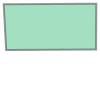

In [14]:
# convert geometry to shapely object (polygon)
# NOTE: the properties dictionary contains the EPSG, one can transform
# the scene geometry to the scene-projection CRS with pyproj
from shapely.geometry import shape
shape(item.geometry)

In [15]:
# access item assets list
item.assets

{'connectivity': <Asset href=https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/red-glacier_sentinel-2_shadows/sentinel-s2-l1c/2021/3/26/S2B_5VMG_20210326_0_L1C/conn.txt>,
 'shadow': <Asset href=https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/red-glacier_sentinel-2_shadows/sentinel-s2-l1c/2021/3/26/S2B_5VMG_20210326_0_L1C/shadow.tif>}

In [16]:
# get the link to a specific asset
item.assets['shadow'].href

'https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/red-glacier_sentinel-2_shadows/sentinel-s2-l1c/2021/3/26/S2B_5VMG_20210326_0_L1C/shadow.tif'

In [17]:
# convenience method to read the assets
da = get_asset(
    catalog,
    "shadow",
    item.id,
    filesystem=dcache,
)
print(da)

<xarray.DataArray (band: 1, y: 984, x: 1553)>
array([[[0.92313697, 0.92660488, 0.93051822, ..., 0.1001129 ,
         0.22803161, 0.20162303],
        [0.92507218, 0.92370764, 0.92255341, ..., 0.10149406,
         0.20031211, 0.29937842],
        [0.92663661, 0.92492   , 0.92344296, ..., 0.0336457 ,
         0.14565633, 0.38316249],
        ...,
        [0.05084327, 0.04170608, 0.05859103, ..., 0.92168011,
         0.92741353, 0.93114467],
        [0.0114759 , 0.02086172, 0.04095467, ..., 0.92033969,
         0.92637953, 0.92555229],
        [0.01835552, 0.02616163, 0.04390395, ..., 0.91671379,
         0.9245579 , 0.92410988]]])
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 6.656e+06 6.656e+06 ... 6.647e+06 6.647e+06
  * x            (x) float64 4.942e+05 4.942e+05 ... 5.097e+05 5.098e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref


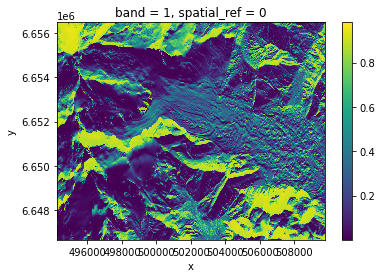

In [19]:
# plot image
da.squeeze().plot.imshow()  # squeeze removes dimensions with size one (band)

In [22]:
# convenience method to read the assets
da = get_asset(
    catalog,
    "connectivity",
    item.id,
    filesystem=dcache,
    driver="textfiles"
)
print(da.splitlines()[:10]) # print first 10 lines

['+494240.27 +6656422.51 +494249.34 +6656472.44 +170.3305 +57.3699', '+494240.29 +6656361.68 +494259.41 +6656470.25 +170.3305 +57.3699', '+494240.30 +6656300.85 +494270.87 +6656479.60 +170.3305 +57.3699', '+494240.31 +6656240.03 +494280.72 +6656478.45 +170.3305 +57.3699', '+494240.33 +6656179.20 +494290.59 +6656476.75 +170.3305 +57.3699', '+494240.34 +6656118.37 +494300.45 +6656474.69 +170.3305 +57.3699', '+494240.35 +6656057.54 +494310.32 +6656472.48 +170.3305 +57.3699', '+494240.37 +6655996.72 +494320.18 +6656470.29 +170.3305 +57.3699', '+494240.38 +6655935.89 +494331.69 +6656479.61 +170.3305 +57.3699', '+494240.39 +6655875.06 +494341.55 +6656478.47 +170.3305 +57.3699']


In [25]:
# download asset locally
copy_asset(
    catalog,
    "shadow",
    item_id=item.id,
    to_uri="./",
    filesystem_from=dcache,
    update_catalog=False
)

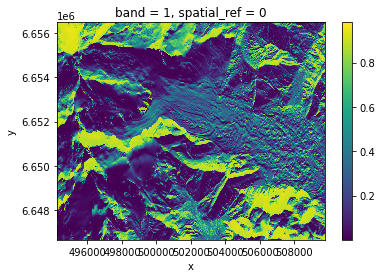

In [27]:
# file is downloaded locally, open it
import rioxarray as rioxr
file_path = f"./{item.id}/shadow.tif"
da = rioxr.open_rasterio(file_path)
da.squeeze().plot.imshow()

In [28]:
# convert catalog to geopandas dataframe 
gdf = catalog2geopandas(catalog)
gdf

,geometry,datetime,platform,constellation,instruments,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,created,updated,data_coverage
S2B_5VMG_20210326_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2021-03-26T21:48:47Z,sentinel-2b,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2B_MSIL1C_20210326T214529_N0209_R129_T05VMG_2...,100.00,61.37,2021-03-27T05:00:45.998Z,2021-03-27T05:00:45.998Z,NaN
S2B_5VMG_20210323_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80440 60.1...",2021-03-23T21:38:50Z,sentinel-2b,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2B_MSIL1C_20210323T213529_N0209_R086_T05VMG_2...,99.08,99.98,2021-03-24T04:49:43.441Z,2021-03-24T04:49:43.441Z,NaN
S2A_5VMG_20210321_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2021-03-21T21:48:47Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20210321T214531_N0209_R129_T05VMG_2...,100.00,67.48,2021-03-22T03:54:09.093Z,2021-03-22T03:54:09.093Z,NaN
S2A_5VMG_20210318_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80456 60.1...",2021-03-18T21:38:50Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20210318T213531_N0209_R086_T05VMG_2...,99.10,78.54,2021-03-19T08:38:31.947Z,2021-03-19T08:38:31.947Z,NaN
S2B_5VMG_20210316_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2021-03-16T21:48:48Z,sentinel-2b,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2B_MSIL1C_20210316T214529_N0209_R129_T05VMG_2...,100.00,37.93,2021-03-19T18:05:29.130Z,2021-03-19T18:05:29.130Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S2A_5VMG_20170220_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2017-02-20T21:45:23Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20170220T214521_N0204_R129_T05VMG_2...,100.00,67.40,2020-09-01T08:02:15.476Z,2020-09-01T08:02:15.476Z,NaN
S2A_5VMG_20170217_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80364 60.1...",2017-02-17T21:35:34Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20170217T213531_N0204_R086_T05VMG_2...,98.98,57.74,2020-09-01T08:02:15.578Z,2020-09-01T08:02:15.578Z,NaN
S2A_5VMG_20170210_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2017-02-10T21:46:24Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20170210T214621_N0204_R129_T05VMG_2...,100.00,43.23,2020-09-01T08:02:15.546Z,2020-09-01T08:02:15.546Z,NaN
S2A_5VMG_20170128_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80264 60.1...",2017-01-28T21:37:32Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20170128T213731_N0204_R086_T05VMG_2...,98.84,46.41,2020-09-01T08:02:15.151Z,2020-09-01T08:02:15.151Z,NaN


In [37]:
# identify which scenes have a specific properties 
# Example: cloud cover lower than 50%
mask = gdf["eo:cloud_cover"] < 50.
subset = gdf[mask]
subset

,geometry,datetime,platform,constellation,instruments,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,created,updated,data_coverage
S2B_5VMG_20210316_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2021-03-16T21:48:48Z,sentinel-2b,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2B_MSIL1C_20210316T214529_N0209_R129_T05VMG_2...,100.00,37.93,2021-03-19T18:05:29.130Z,2021-03-19T18:05:29.130Z,NaN
S2B_5VMG_20210303_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80430 60.1...",2021-03-03T21:38:50Z,sentinel-2b,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2B_MSIL1C_20210303T213529_N0209_R086_T05VMG_2...,99.07,15.16,2021-03-04T04:15:40.175Z,2021-03-04T04:15:40.175Z,NaN
S2A_5VMG_20210206_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80577 60.2...",2021-02-06T21:38:50Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20210206T213651_N0209_R086_T05VMG_2...,99.27,21.82,2021-02-07T00:43:27.705Z,2021-02-07T00:43:27.705Z,NaN
S2B_5VMG_20210204_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2021-02-04T21:48:48Z,sentinel-2b,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2B_MSIL1C_20210204T214709_N0209_R129_T05VMG_2...,100.00,25.18,2021-02-05T00:51:05.790Z,2021-02-05T00:51:05.790Z,NaN
S2B_5VMG_20210201_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80528 60.2...",2021-02-01T21:38:51Z,sentinel-2b,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2B_MSIL1C_20210201T213719_N0209_R086_T05VMG_2...,99.21,6.45,2021-02-02T01:50:19.161Z,2021-02-02T01:50:19.161Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S2A_5VMG_20170319_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80240 60.1...",2017-03-19T21:35:21Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20170319T213521_N0204_R086_T05VMG_2...,98.79,13.51,2020-09-01T08:02:15.514Z,2020-09-01T08:02:15.514Z,NaN
S2A_5VMG_20170312_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2017-03-12T21:45:21Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20170312T214521_N0204_R129_T05VMG_2...,100.00,28.16,2020-09-01T08:02:15.626Z,2020-09-01T08:02:15.626Z,NaN
S2A_5VMG_20170210_0_L1C,"POLYGON ((-154.76387 59.43863, -154.81699 60.4...",2017-02-10T21:46:24Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20170210T214621_N0204_R129_T05VMG_2...,100.00,43.23,2020-09-01T08:02:15.546Z,2020-09-01T08:02:15.546Z,NaN
S2A_5VMG_20170128_0_L1C,"POLYGON ((-154.76387 59.43863, -154.80264 60.1...",2017-01-28T21:37:32Z,sentinel-2a,sentinel-2,[msi],10,0,32605,5,V,MG,0,S2A_MSIL1C_20170128T213731_N0204_R086_T05VMG_2...,98.84,46.41,2020-09-01T08:02:15.151Z,2020-09-01T08:02:15.151Z,NaN


In [38]:
# get the scene IDs to be used e.g. to read/download the corresponding assets
item_ids = subset.index
item_ids

Index(['S2B_5VMG_20210316_0_L1C', 'S2B_5VMG_20210303_0_L1C',
       'S2A_5VMG_20210206_0_L1C', 'S2B_5VMG_20210204_0_L1C',
       'S2B_5VMG_20210201_0_L1C', 'S2A_5VMG_20210130_0_L1C',
       'S2B_5VMG_20210125_0_L1C', 'S2A_5VMG_20201118_0_L1C',
       'S2B_5VMG_20201113_0_L1C', 'S2B_5VMG_20201103_0_L1C',
       ...
       'S2B_5VMG_20170821_0_L1C', 'S2A_5VMG_20170819_0_L1C',
       'S2B_5VMG_20170712_0_L1C', 'S2A_5VMG_20170511_0_L1C',
       'S2A_5VMG_20170421_0_L1C', 'S2A_5VMG_20170319_0_L1C',
       'S2A_5VMG_20170312_0_L1C', 'S2A_5VMG_20170210_0_L1C',
       'S2A_5VMG_20170128_0_L1C', 'S2A_5VMG_20170118_0_L1C'],
      dtype='object', length=154)

In [40]:
# for item_id in item_ids:
#     copy_asset(..., item_id=item_id, ...)